<a href="https://colab.research.google.com/github/NyashaNziramasanga/Masters-of-Computer-Science/blob/master/2021-Semester-2/COMP8715-heuristic-optimisation/Week5-feature-normalisation/practical/COMP2712_2021_Practical03_Checkpoint04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COMP2712 Practical03, Checkpoint04: Digits with Keras and Activation Functions

This example walks through classifying digits from the MNIST digit data set.  It introduces and uses the TensorFlow and Keras machine learning modules (instead of the sckit-learn) but only looks at classifying with 'shallow', MLP-like networks.

The prac explores the use of different **activiation functions**.

Adapted from this most excellent machine learning tutorial: [Deep Learning Basics](https://colab.research.google.com/github/lexfridman/mit-deep-learning/blob/master/tutorial_deep_learning_basics/deep_learning_basics.ipynb)

## Getting Ready

### Install a module for multi-class bookmaker

In [ ]:
!pip install pycm

### Load some modules
- [tensorflow](https://www.tensorflow.org/): TensorFlow is an end-to-end open source platform for machine learning.
- [tensorflow.keras](https://www.tensorflow.org/guide/keras):TensorFlow's high-level API for building and training deep learning models. 

and we have seen the other modules before

- [numpy](https://numpy.org/): is the fundamental package for scientific computing with Python
- [pandas](https://pandas.pydata.org/): a fast, powerful, flexible and easy to use open source data analysis and manipulation tool
- [maplotlib](https://matplotlib.org/): a comprehensive library for creating static, animated, and interactive visualizations in Python
- [seaborn](https://seaborn.pydata.org/) : Seaborn is a Python data visualization library based on matplotlib. 
- [sklearn](https://scikit-learn.org/): an open source machine learning library that supports supervised and unsupervised learning. 


In [ ]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense

# Commonly used modules
import numpy as np
import os
import sys

# Images, plots, display, and visualization
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

#scikit for machine learning reporting
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

import pycm

# timing
import time

In [ ]:
print(tf.__version__)

2.6.0


### Load the MNIST digit data

The [MNIST dataset](http://yann.lecun.com/exdb/mnist/) contains 70,000 grayscale images of handwritten digits at a resolution of 28 by 28 pixels.

In [ ]:
(train_images, train_labels), (test_images, test_labels) = keras.datasets.mnist.load_data()

# reshape images to specify that it's a single channel
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1)
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1)

In [ ]:
np.shape(train_images)

(60000, 28, 28, 1)

In [ ]:
def preprocess_images(imgs): # should work for both a single image and multiple images
    sample_img = imgs if len(imgs.shape) == 2 else imgs[0]
    assert sample_img.shape in [(28, 28, 1), (28, 28)], sample_img.shape # make sure images are 28x28 and single-channel (grayscale)
    return imgs / 255.0

train_images = preprocess_images(train_images)
test_images = preprocess_images(test_images)

print('training shape: {0}'.format(np.shape(train_images)))
print('testing shape: {0}'.format(np.shape(test_images)))

training shape: (60000, 28, 28, 1)
testing shape: (10000, 28, 28, 1)


### View the image data (sanity check)

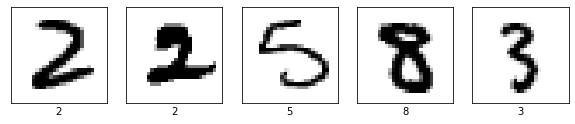

In [ ]:
plt.figure(figsize=(10,2))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    image_idx = np.random.randint(0,train_images.shape[0])
    plt.imshow(train_images[image_idx].reshape(28, 28), cmap=plt.cm.binary)
    plt.xlabel(train_labels[image_idx])

### Flatten the image data from 2D to 1D

Many classifier cannot handle the 2D (or more) dimensional strucutre of images.  We can "flatten" the data to 1D by stacking or reshaping the 2D into 1D.  For example, If the image dimesion is 28x28 this will convert into a 28 * 28 = 784 single dimension feature vector.

In [ ]:
print('shape of the train_images: {0}'.format(train_images.shape))
n_samples = len(train_images)
train_images_flatten = train_images.reshape((n_samples, -1))
print('shape of the train_images_flatten: {0}'.format(train_images_flatten.shape))

print('shape of the test_images: {0}'.format(test_images.shape))
n_samples = len(test_images)
test_images_flatten = test_images.reshape((n_samples, -1))
print('shape of the test_images_flatten: {0}'.format(test_images_flatten.shape))

shape of the train_images: (60000, 28, 28, 1)
shape of the train_images_flatten: (60000, 784)
shape of the test_images: (10000, 28, 28, 1)
shape of the test_images_flatten: (10000, 784)


### Target Data

The target data is essentially in an integer encoding.  Let's make a One Hot encoding as well.

In [ ]:
print('shape of train_labels: {}',format(np.shape(train_labels)))
print('unique values of train_labels: {}'.format(np.unique(train_labels)))

# one hot encoding - much easier using keras!
train_labels_oh = tf.keras.utils.to_categorical(train_labels)
test_labels_oh = tf.keras.utils.to_categorical(test_labels)

print('shape of train_labels_oh: {}'.format(np.shape(train_labels_oh)))
print('value of train_labels_oh[1,:]: {} => {}'.format(train_labels_oh[1,:],train_labels[1]))
label_idx = np.random.randint(0,train_labels_oh.shape[0])
print('value of train_labels_oh[{},:]: {} => {}'.format(label_idx, train_labels_oh[label_idx,:],train_labels[label_idx]))

shape of train_labels: {} (60000,)
unique values of train_labels: [0 1 2 3 4 5 6 7 8 9]
shape of train_labels_oh: (60000, 10)
value of train_labels_oh[1,:]: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.] => 0
value of train_labels_oh[47540,:]: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.] => 9


## Classification of MNIST with Single Hidden Layer
Let's start "easy" with a single hidden layer like an MLP but using the Tensor and Keras modules.

### Build the model

Building the neural network requires configuring the layers of the model, then compiling the model. First we stack a few layers together using `keras.Sequential`. Next we configure the loss function, optimizer, and metrics to monitor. These are added during the model's compile step:

* *Loss function* - measures how accurate the model is during training, we want to minimize this with the optimizer.
* *Optimizer* - how the model is updated based on the data it sees and its loss function.
* *Metrics* - used to monitor the training and testing steps.

Let's build a network with **1 hidden layer of 5 neurons**, and use categorical_crossentropy as the loss function (most common one for classfication problems):

In [ ]:
def build_simple_model(activation='relu',number_hidden_nodes=5):

    number_of_features = len(train_images_flatten[0])
    number_of_output = len(train_labels_oh[0])
    print('Number of input features: {}'.format(number_of_features))
    print('Number of hidden nodes: {}'.format(number_hidden_nodes))
    print('Activation Function on hidden layer: {}'.format(activation))
    print('Number of out classes: {}'.format(number_of_output))

    model = keras.Sequential([
        Dense(number_hidden_nodes, activation=activation, input_shape=[number_of_features]),
        Dense(number_of_output, activation=tf.nn.sigmoid)
    ])

    model.compile(optimizer=tf.optimizers.Adam(),
                  loss=keras.losses.categorical_crossentropy,
                  metrics=keras.metrics.categorical_crossentropy)
    return model


### Checkpoint04: Train the model with different acitvation functions

Training the neural network model requires the following steps:

1. Feed the training data to the model—in this example, the `train_images_flatten` and `train_labels_oh` arrays.
2. The model learns to associate features and labels.
3. We ask the model to make predictions about a test set—in this example, the `test_features_flatten` array. We verify that the predictions match the labels from the `test_labels_oh` array. 

We can adjust the activation (or transfer) function of the hidden layer by passing a different value for activation.  See here for a list of different activation functions for keras models:
https://keras.io/api/layers/activations/

To start training,  call the `model.fit` method—the model is "fit" to the training data:

In [ ]:
# Checkpoint04: Experiment with different activation functions
activation = 'sigmoid' # select from [None, 'sigmoid', 'tanh', 'relu']:
number_hidden_nodes = 5

# build the model
model = build_simple_model(activation=activation,number_hidden_nodes=number_hidden_nodes)

# train the model and time how long it takes
no_epochs = 5
print('Training with {0} for {1}'.format(activation, no_epochs))
tic = time.perf_counter()
history = model.fit(train_images_flatten, train_labels_oh, epochs=no_epochs, verbose=1)
toc = time.perf_counter()
elapsed_time = toc - tic
print('\nTraining took {:0.4f} seconds'.format(elapsed_time))


# eval the model (on training data)
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

loss_final = np.sqrt(float(hist['loss'].tail(1)))
print()
print('Final Loss on training set: {}'.format(round(loss_final, 3)))

Number of input features: 784
Number of hidden nodes: 5
Activation Function on hidden layer: sigmoid
Number of out classes: 10
Training with sigmoid for 5
Epoch 1/5
1875/1875 [==============================] - 5s 2ms/step - loss: 1.6703 - categorical_crossentropy: 1.6703
Epoch 2/5
1875/1875 [==============================] - 4s 2ms/step - loss: 1.0577 - categorical_crossentropy: 1.0577
Epoch 3/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.8365 - categorical_crossentropy: 0.8365
Epoch 4/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.7269 - categorical_crossentropy: 0.7269
Epoch 5/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.6680 - categorical_crossentropy: 0.6680

Training took 22.2002 seconds

Final Loss on training set: 0.817


In [ ]:
hist

,loss,categorical_crossentropy,epoch
0,1.625984,1.625984,0
1,0.990936,0.990936,1


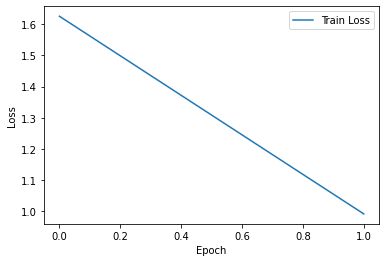

In [ ]:
def plot_history():
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(hist['epoch'], hist['loss'], label='Train Loss')
    plt.legend()

plot_history()

### Test Performance
Next, compare how the model performs on the test dataset:

In [ ]:
[loss, crossent] = model.evaluate(test_images_flatten, test_labels_oh)
print('Loss on test set: {}'.format(round(loss, 3)))

# Calculat all the predictions on the test set
y_pred_real = model.predict(test_images_flatten)
y_pred = np.argmax(y_pred_real, axis=-1)


label_idx = np.random.randint(0,test_labels_oh.shape[0])
print('random instance: {}, pred: {}, actual: {}'.format(label_idx,y_pred[label_idx],test_labels[label_idx]))


313/313 [==============================] - 1s 2ms/step - loss: 0.4267 - categorical_crossentropy: 0.4267
Loss on test set: 0.427
random instance: 719, pred: 4, actual: 4


Run the below cell multiple times to see different, random predictions

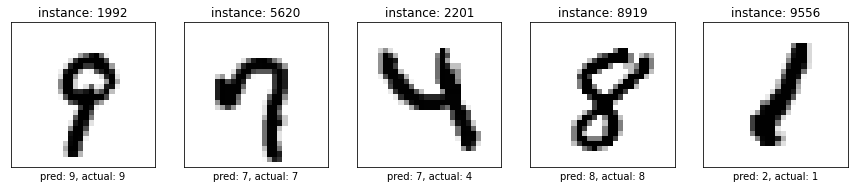

In [ ]:
plt.figure(figsize=(15,5))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    image_idx = np.random.randint(0,test_images.shape[0])
    plt.imshow(test_images[image_idx].reshape(28, 28), cmap=plt.cm.binary)
    plt.xlabel('pred: {}, actual: {}'.format(y_pred[image_idx],test_labels[image_idx]))
    plt.title('instance: {}'.format(image_idx))


View the statistics on the classifier performance on the test set.

              precision    recall  f1-score   support

           0       0.90      0.98      0.94       980
           1       0.95      0.97      0.96      1135
           2       0.90      0.88      0.89      1032
           3       0.87      0.81      0.84      1010
           4       0.86      0.87      0.87       982
           5       0.80      0.76      0.78       892
           6       0.85      0.89      0.87       958
           7       0.91      0.89      0.90      1028
           8       0.86      0.83      0.84       974
           9       0.85      0.86      0.85      1009

    accuracy                           0.88     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.88      0.88      0.88     10000

f1 score: 0.877
Bookmaker Informedness
Bookmaker: 0.866
Per Class: [0.9691931761618173, 0.968357968648673, 0.8722356492334502, 0.7948953182303771, 0.8571842510950041, 0.743776722183819, 0.8726529732046091, 0.8779896296476197, 0.8109483850214

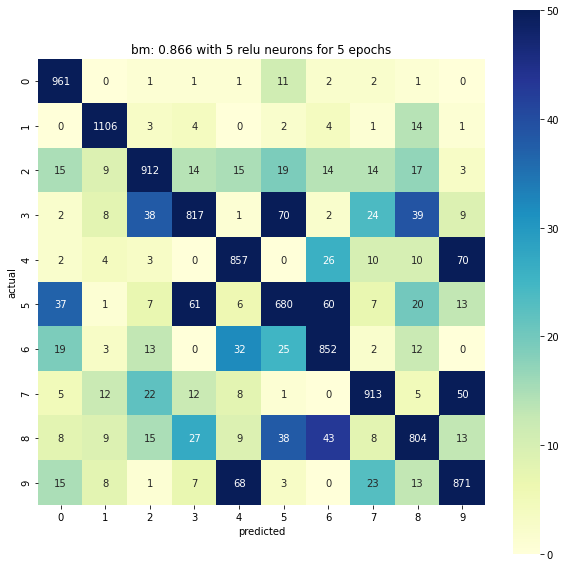

In [ ]:
def bookmaker(test_labels, y_pred):
  # calculate bm over classes using the pycm library
  cm = pycm.ConfusionMatrix(actual_vector=test_labels,predict_vector=y_pred)
  bmclass = list(cm.BM.values())

  # now calculate bias and the overall bookmaker
  cm = confusion_matrix(test_labels, y_pred)
  bias = np.sum(cm,axis=0) / np.sum(cm)

  bm = np.sum(bmclass*bias)
  
  return bm, bmclass

cr = classification_report(test_labels,y_pred)
print(cr)
f1 = f1_score(test_labels, y_pred,average='weighted')

print('f1 score: {:.3f}'.format(f1))

print('Bookmaker Informedness')
bm, bmclass = bookmaker(test_labels, y_pred)
print('Bookmaker: {:.3f}'.format(bm))
print('Per Class: {}'.format(bmclass))

# Produce a Confusion Matrix to visualise more easily where errors and confusion occur in the classification of the digits.
cm = confusion_matrix(test_labels, y_pred)
print()
print(cm)

class_labels = np.unique(test_labels);
df_cm = pd.DataFrame(cm, columns=class_labels, index=class_labels)
fig, ax1 = plt.subplots(1,1, figsize=(10,10))
sns.heatmap(df_cm, annot=True, ax=ax1,square=True,  cmap="YlGnBu",vmin=0,vmax=50,fmt='d')
ax1.set_title('bm: {:.3f} with {} {} neurons for {} epochs'.format(bm,number_hidden_nodes,activation,no_epochs) )
ax1.set_xlabel('predicted')
ax1.set_ylabel('actual');